# 文本的处理

- 词向量化

## 数据读取

In [14]:
import os
import re

# 读取数据
data_sms = []
with open(os.path.join('./rnn', 'SMSSpamCollection'), 'r') as fd:
    for sms in fd:
        data_sms.append(sms)

# 最后一行是空行，丢弃最后空行
data_sms = data_sms[:-1]


## 数据处理：格式化与清洗

In [15]:
# 注意每行的短信类别使用\t分隔，每行使用\n分隔。
data_sms = [sms.split('\t') for sms in data_sms if len(sms)>=1]
# 把短信的类别与内容分成两个列表 
[target, data] = [list(sms) for sms in zip(*data_sms)]


# 对短信内容进行清洗
new_data = []
for sms in  data:
    sms = re.sub(r'([^\s\w]|_|[0-9])+', '', sms)  # 删除不必要的符号
    sms = " ".join(sms.split())   # 去掉\n
    sms = sms.lower()   # 小写转换
    new_data.append(sms)
data =new_data


## 词向量化

In [16]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.contrib.learn import preprocessing
import numpy as np
# 词向量（可以使用sklearn的库）
max_sequence_length = 25     # 词向量化后的向量维数。
min_word_frequency = 10      # 处理的词出现的最小频率

# 词表处理类（不推荐使用）:取唯一出现的词，形成词表（每个词有一个编号）
vocab_processor = preprocessing.VocabularyProcessor(max_sequence_length,  min_frequency=min_word_frequency)

# vocab_processor = preprocessing.VocabularyProcessor(100)
# 转换为ndarray对象
data = np.array(list(vocab_processor.fit_transform(data)))
print(data)
print(data.shape)
# ----------------------------（标签）
# 标签的数值化
target = np.array([1 if t=='ham' else 0 for t in target])    # 二值化标签

print( '词表大小', len(vocab_processor.vocabulary_)  )# 词表数量


[[ 44 456   0 ...   0   0   0]
 [ 47 316   0 ...   0   0   0]
 [ 46 466   9 ...   0 369   0]
 ...
 [ 34  75 151 ...   0   0   0]
 [  0  59   9 ...   0   0   0]
 [  5 494 109 ...   1 199  12]]
(5573, 25)
词表大小 934


- 上面的短信数据已经数值化，但是不适合做训练。
    - 后面转为随机的小数（这个随机数基本上唯一代表这个词）：把单词随机转换为一个小数，这个小数代表这个词。
    - 适合循环神经网络的输入数据格式（维度）

## 数据切分与打乱

In [17]:
# 对数据集洗牌
shuffled_idx = np.random.permutation(np.arange(len(data)))

# 使用打乱的索引，得到打乱的数据
x_data = data[shuffled_idx]
y_data = target[shuffled_idx]

# 切分训练集与测试集
num_train = int(len(x_data)*0.80)  # 取80%作为训练集

x_train, x_test = x_data[:num_train], x_data[num_train:]
y_train, y_test = y_data[:num_train], y_data[num_train:]

vocab_size = len(vocab_processor.vocabulary_)  # 词表数量
print(F"词表数量 {vocab_size: d}")


词表数量  934


# 循环神经网络模型

## 定义输入
- 把整数化的短信文本小数化。

In [18]:
embedding_size = 5  # 时序展开的长度

import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()    # 整个环境的图清空。防止产生多个图。

# 定义占位
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])   # 该数据不符合循环神经网络格式，max_sequence_length=25
y_output = tf.placeholder(tf.int32, [None])   # 训练样本的标签

# 短信->随机向量
# 把输入数据转换为循环神经网络需要的数据格式（同时把数据映射成随机数：这里可以使用其他类似的词向量化技术）
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))    # 随机表 （一列就是一个样本）

# embedding_output 实际就是短息数据数值化以后的形式。最后一维就是时序。（有重复）
# embedding_output是时序的训练样本
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)    # 使用x_data作为下标，直接从随机表中取一个随机与下标对标



- 循环神经网络与贝叶斯的文本分类：
    - 循环神经网络，不存在词频的统计
    - 贝叶斯的核心就是词频统计。

## 定义循环层

In [19]:
import warnings
warnings.filterwarnings("ignore")

rnn_size = 5   # 层数
# 循环层
cell = tf.nn.rnn_cell.BasicRNNCell(num_units = rnn_size)
# 实现时序循环
output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)   # 循环层的展开（静态方式，动态方式）

## 定义输出层

In [20]:
output = tf.transpose(output, [1, 0, 2])    # 交换维度位置：格式化

last = tf.gather(output, int(output.get_shape()[0]) - 1)   # 取最后作为识别结果，gather根据下标取值（值计算最后输出的误差）

# 输出层就是全连接层
# 加权求和
weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))

# 激活函数
logits_out = tf.nn.softmax(tf.matmul(last, weight) + bias)

## 损失函数与优化器

In [21]:
import warnings
warnings.filterwarnings("ignore")

# 使用稀疏softmax交叉熵损失函数
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_output, logits=logits_out) # 结果绝对在0-1之间：适合作为概率（归一化）
loss = tf.reduce_mean(losses)

# 用来观察准确度（分类正确率）cast类型转换
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))

# 梯度下降优化器
optimizer = tf.train.RMSPropOptimizer(0.0005)
train_step = optimizer.minimize(loss)

# 训练与评估

In [22]:
import tensorflow as tf

epochs = 200
batch_size = 200
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

# 存放训练的数据，用来可视化
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# 循环训练epochs轮
for epoch in range(epochs):

    # 打乱数据
    shuffled_idx = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_idx]
    y_train = y_train[shuffled_idx]
    # 计算训练次数
    num_batches = int(len(x_train)/batch_size) + 1
    # 每批次进行一次训练
    for i in range(num_batches):
        # Select train data
        min_idx = i * batch_size
        max_idx = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_idx:max_idx]
        y_train_batch = y_train[min_idx:max_idx]
        
        # 训练的输入数据
        train_dict = {x_data: x_train_batch, y_output: y_train_batch}
        # 开始训练
        sess.run(train_step, feed_dict=train_dict)
        
    # 计算训练集的损失与准确度
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    
    # 计算测试集的损失预准确度
    test_dict = {x_data: x_test, y_output: y_test}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print(F'轮数: {epoch+1}, 测试集损失: {temp_test_loss:.2}, 测试集准确度: {temp_test_acc:.2}')

轮数: 1, 测试集损失: 0.68, 测试集准确度: 0.82
轮数: 2, 测试集损失: 0.67, 测试集准确度: 0.83
轮数: 3, 测试集损失: 0.66, 测试集准确度: 0.83
轮数: 4, 测试集损失: 0.65, 测试集准确度: 0.83
轮数: 5, 测试集损失: 0.63, 测试集准确度: 0.83
轮数: 6, 测试集损失: 0.62, 测试集准确度: 0.83
轮数: 7, 测试集损失: 0.6, 测试集准确度: 0.83
轮数: 8, 测试集损失: 0.59, 测试集准确度: 0.84
轮数: 9, 测试集损失: 0.57, 测试集准确度: 0.84
轮数: 10, 测试集损失: 0.56, 测试集准确度: 0.84
轮数: 11, 测试集损失: 0.55, 测试集准确度: 0.84
轮数: 12, 测试集损失: 0.54, 测试集准确度: 0.85
轮数: 13, 测试集损失: 0.52, 测试集准确度: 0.85
轮数: 14, 测试集损失: 0.51, 测试集准确度: 0.85
轮数: 15, 测试集损失: 0.51, 测试集准确度: 0.85
轮数: 16, 测试集损失: 0.5, 测试集准确度: 0.85
轮数: 17, 测试集损失: 0.49, 测试集准确度: 0.85
轮数: 18, 测试集损失: 0.49, 测试集准确度: 0.85
轮数: 19, 测试集损失: 0.48, 测试集准确度: 0.85
轮数: 20, 测试集损失: 0.48, 测试集准确度: 0.85
轮数: 21, 测试集损失: 0.47, 测试集准确度: 0.85
轮数: 22, 测试集损失: 0.47, 测试集准确度: 0.86
轮数: 23, 测试集损失: 0.47, 测试集准确度: 0.86
轮数: 24, 测试集损失: 0.47, 测试集准确度: 0.86
轮数: 25, 测试集损失: 0.46, 测试集准确度: 0.86
轮数: 26, 测试集损失: 0.46, 测试集准确度: 0.86
轮数: 27, 测试集损失: 0.46, 测试集准确度: 0.86
轮数: 28, 测试集损失: 0.46, 测试集准确度: 0.86
轮数: 29, 测试集损失: 0.46, 测试集准确度: 0.86
轮数: 30, 测试集损失: 0.46, 测试集准

## 模型评估

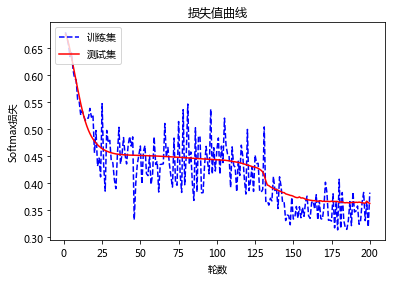

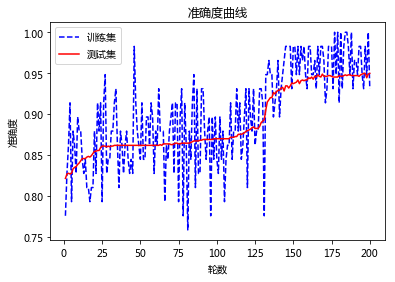

In [23]:
% matplotlib inline
import matplotlib.pyplot as plt

epoch_seq = np.arange(1, epochs+1)   # 定制显示x坐标，训练的轮数

plt.plot(epoch_seq, train_loss, 'b--', label='训练集')
plt.plot(epoch_seq, test_loss, 'r-', label='测试集')
plt.title('损失值曲线')
plt.xlabel('轮数')
plt.ylabel('Softmax损失')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'b--', label='训练集')
plt.plot(epoch_seq, test_accuracy, 'r-', label='测试集')
plt.title('准确度曲线')
plt.xlabel('轮数')
plt.ylabel('准确度')
plt.legend(loc='upper left')
plt.show()